## Figure 9 -- discovery study

In [1]:
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path
import pickle

import hypney.all as hp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

import common

# Comment out the line below if you don't have a LaTeX installation
plt.rcParams["text.usetex"] =  True

## Feldman-cousins intervals

Just another implementation of [ https://arxiv.org/abs/physics/9711021 ]

In [2]:
# Grid of hypotheses: expected signal events
mu = np.concatenate([np.array([0]), np.geomspace(0.1, 200, 10_000)])
confidence_level = 0.9

def fc_limits(mu_bg=0, confidence_level=confidence_level, mu=mu):
    # Total expected events
    mu_tot = mu + mu_bg
    # best-fit total mu
    n = np.arange(stats.poisson(mu.max()).ppf(0.999)).astype(int)
    mu_tot_best = (n - mu_bg).clip(0, None) + mu_bg
    # Make (mu, n) arrays
    o = None
    # Probability of observation (given hypothesis)
    p = stats.poisson(mu_tot[:,o]).pmf(n[o,:])
    # -2 likelihood ratio of observation (given hypothesis)
    t = -2 * ( 
        # Log P(test)
        stats.poisson(mu_tot[:,o]).logpmf(n[o,:]) 
        # Log P(best fit)
        - stats.poisson(mu_tot_best[o,:]).logpmf(n[o,:]) )

    # Build Neyman band for Feldman-Cousins
    excluded = t != t
    for i in range(len(mu)):
        # Arrays to order ns by *descending* t (likely observations LAST)
        # and to undo that order
        order = np.argsort(-t[i])
        undo_order = np.argsort(order)
        # Exclude observations with highest ts and probability summing to <0.1
        excluded[i] = (np.cumsum(p[i][order]) < (1 - confidence_level))[undo_order]
    # Include mus in between included mus (ensure continuous intervals)
    for j in range(len(n)):
        excluded[:,j] = (
            np.minimum.accumulate(excluded[:,j])
            | np.minimum.accumulate(excluded[:,j][::-1])[::-1])
    
    # Convert band to limit lookup arrays for each observed n
    # Upper limit: mu is excluded, but mu just below it (roll
    # forward to align) is allowed. 
    # Argmax picks out the single true value; we already included mus
    # between included mus.
    upper = mu[np.argmax(excluded & np.roll(~excluded, 1, axis=0), axis=0)]
    # Convert band to limit lookup arrays for each observed n
    # Upper limit: mu is excluded, but mu just above it (roll
    # back to align) is allowed. 
    # (Still need argmax: argmin would pick out the first False value.)
    lower = mu[np.argmax(excluded & np.roll(~excluded, -1, axis=0), axis=0)]
    
    # Correct np.roll artifacts
    upper[upper == mu[-1]] = 0   
    lower[lower == mu[-1]] = 0
    
    # Coverage = probability truth is excluded
    # (mu, n arrays inside, then sum over n)
    # TODO: what about < vs <= here? For dense enough mu it shouldn't matter.
    # Let's say we quote closed intervals on mu.
    false_lower = np.sum(p * (lower[None,:] > mu[:,None]), axis=1)
    false_upper = np.sum(p * (upper[None,:] < mu[:,None]), axis=1)
    coverage = np.sum(
        p * ((upper[None,:] >= mu[:,None])
             & (lower[None,:] <= mu[:,None])),
        axis=1)   
    
#     # Quantiles to compute for sensitivity 
#     quantiles = stats.norm.cdf([-2, -1, 0, 1, 2])
        
#     # First compute the +-1 sigma observations (for no signal).
#     n_m2, n_m1, n_med, n_p1, n_p2 = [
#         find_quantile(q, mu_bg)
#         for q in quantiles]
    
#     # Convert to quantiles of upper and lower limits
#     def get_index(n_q):
#         return np.argmin(np.abs(n - n_q))
#     u_m2, u_m1, u_med, u_p1, u_p2 = [
#         upper[get_index(n_q)]
#         for n_q in (n_m2, n_m1, n_med, n_p1, n_p2)]
#     l_m2, l_m1, l_med, l_p1, l_p2 = [
#         upper[get_index(n_q)]
#         for n_q in (n_m2, n_m1, n_med, n_p1, n_p2)]
    
#     # Lowest n observed that gives a discovery 
#     # At this n, or higher, the lower limit is > 0
#     n_discovery = n[np.where(lower > 0)[0].min()]

#     # Discovery power for each mu
#     # = fraction of trials that have a nonzero lower limit
#     # Note sf doesn't include p of argument itself, unlike cdf
#     disc_power = stats.poisson(mu_tot).sf(np.round(n_discovery) - 1)

    return dict(
        mu_bg=mu_bg,
        n=n,
        lower=lower,
        upper=upper,
        excluded=excluded,
        
        false_upper=false_upper,
        false_lower=false_lower,
        coverage=coverage,
        
        # Plus/minus 2-1-0 sigma quantiles of n, upper limit, and lower limit
        # n_m2=n_m2, n_m1=n_m1, n_med=n_med, n_p1=n_p1, n_p2=n_p2,
        # u_m2=u_m2, u_m1=u_m1, u_med=u_med, u_p1=u_p1, u_p2=u_p2,
        # l_m2=u_m2, l_m1=u_m1, l_med=u_med, l_p1=u_p1, l_p2=u_p2,
        # n_discovery=n_discovery,
        # disc_power=disc_power
    )

def find_quantile(q, mu_bg):
    """Return the n at the background-only quantile q"""
    return stats.poisson(mu_bg).ppf(q)

To check we didn't mess up: compare the plot below with figure 7 in Feldman&Cousins (p.26). 

There is one difference: the band here steps _in between_ possible values of n, rather than _at_ n values. That's OK, it just makes it unambiguous whether boundary values are included or not. Read off confidence intervals using the red dots at an observed n.

Text(0.5, 1.0, '3 expected background events')

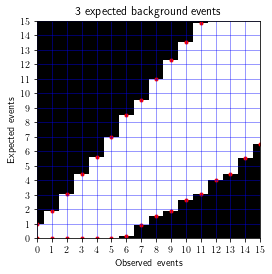

In [3]:
q = fc_limits(mu_bg=3)

plt.figure(figsize=(4,4))
plt.pcolormesh(q['n'], mu, q['excluded'], shading='nearest', cmap=plt.cm.Greys)

plt.scatter(q['n'], q['upper'], c='r', marker='.')
plt.scatter(q['n'], q['lower'], c='r', marker='.')

plt.xticks(np.arange(16))
plt.yticks(np.arange(16))
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.grid(c='b', alpha=0.5)
plt.ylabel("Expected events")
plt.xlabel("Observed events")
plt.title(f"{q['mu_bg']} expected background events")

And compare this with table IV on p. 37:

In [4]:
q['lower'][7], q['upper'][7]

(0.8942356711945959, 9.531591009140486)

Check probability of false upper and lower limits, which we need below. Since Feldman-Cousins intervals are never empty, their sum should equal the total false exclusion probability -- until we get to mus near the end of the considered posible range (mu>>100 here, just adjust linspace above to consider higher ones).

Text(0.5, 1.0, '3 expected background events')

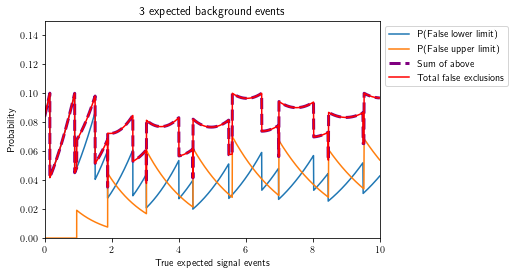

In [5]:
plt.plot(mu, q['false_lower'], 
         label='P(False lower limit)')
plt.plot(mu, q['false_upper'], 
         label='P(False upper limit)')
plt.plot(mu, q['false_upper'] + q['false_lower'],
         label='Sum of above',
         linestyle='--', c='purple', linewidth=3)
plt.plot(mu, 1 - q['coverage'], 
         label='Total false exclusions',
         c='r')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

plt.xlabel("True expected signal events")
plt.xlim(0, 10)

plt.ylabel("Probability")
plt.ylim(0, 0.15)

plt.title(f"{q['mu_bg']} expected background events")

## Example experiment with a background-free core

In [6]:
f_core = 0.3

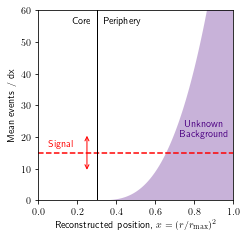

In [7]:
# Example experiment, shifted to periphery
# See cylinder.ipynb notebook
similarity = 0.25
mu_unknown = 20
background = common.powerlaw(mu=mu_unknown, alpha=similarity)
scale = 1 - f_core
background = background(loc=f_core, scale=1-f_core)
assert background.min() == f_core
assert background.max() == 1
signal = hp.uniform()
# x = np.linspace(0, 1.1, 1000)
# signal(rate=10).plot_diff_rate(x)
# background.plot_diff_rate(x)

rs = np.linspace(0, 1, 1000)

plt.figure(figsize=(3.5, 3.5))

#plt.scatter(data, 0 * data, c='k', clip_on=False, s=10)
#plt.text(0.6, 4, "Example dataset", c='k')

# Background dist
c = 'indigo'
plt.fill_between(rs, 0, background.diff_rate(rs), 
                 color=c, alpha=0.3, linewidth=0)
plt.text(0.72, 20, 'Unknown\nBackground', c='indigo', ma='center')

# Signal marker
mu_sig = 15
y_text = mu_sig + 2
plt.axhline(mu_sig, linestyle='--', c='r')
plt.text(0.05, y_text, 'Signal', c='r')
arrow_x = 0.25
sig_amp = 0.4
plt.annotate("", xy=(arrow_x, mu_sig * (1 - sig_amp)), 
             xytext=(arrow_x, mu_sig * (1 + sig_amp)),
             arrowprops=dict(arrowstyle='<->', color='r'))

# Core marker
plt.axvline(f_core, c='k', linewidth=1)
plt.text(f_core - 0.03, 58, "Core", ha='right', va='top')
plt.text(f_core + .03, 58, "Periphery", ha='left', va='top')

plt.ylabel("Mean events / dx")
plt.ylim(0, 60)

plt.xlabel("Reconstructed position, $x = (r / r_\mathrm{max})^2$")
plt.xlim(0, 1)

for fmt in ('png', 'pdf'):
    plt.savefig(f'example_experiment_core.{fmt}', dpi=200, bbox_inches='tight')

## Find $\alpha_\text{lower}$, the false discovery probability (step 2)

For a simple procedure like Feldman-Cousins counting, this is easy to compute.

Text(0.5, 0, 'Expected signal events in the full experiment')

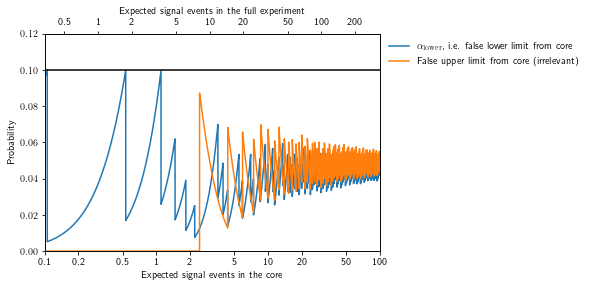

In [8]:
# P(False discovery | mu in core)
fc_limit_info = fc_limits(mu_bg=0)  # no known background
false_lower_core = fc_limit_info['false_lower']

mu_full = hp.DEFAULT_RATE_GRID
alpha_lower = np.interp(x=mu_full, xp=mu / f_core, fp=false_lower_core)
# High res version for determining which hypotheses can never be excluded
alpha_lower_hr = np.interp(x=mu, xp=mu / f_core, fp=false_lower_core)

plt.plot(mu, false_lower_core, label=r'$\alpha_\mathrm{lower}$, i.e. false lower limit from core')
plt.plot(mu, fc_limit_info['false_upper'], label='False upper limit from core (irrelevant)')
plt.axhline(1 - confidence_level, c='k')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
plt.xlabel("Expected signal events in the core")
plt.ylabel("Probability")
common.log_x(0.1, 100)
plt.ylim(0, 0.12)
#plt.grid()

plt.twiny()
common.log_x(0.1 / f_core, 100 / f_core)
plt.xlabel("Expected signal events in the full experiment")

In [9]:
# Deficit hawk cannot exclude this hypothesis, because alpha is saturated
mu_never_exclude = mu[np.where(alpha_lower_hr > 0.099)[0][-1]]
mu_never_exclude, mu_never_exclude * f_core

(3.665932215167418, 1.0997796645502254)

## Setup deficit hawk with modified critical value (step 3)

In [11]:
signal = hp.uniform().fix_except('rate')
stat = hp.FixedRegionSimpleHawk(
    signal, 
    signal_only=True, 
    # Test 100 options for [0, between 0.3 and 1.0]
    # This is a fine approximation to testing _all_ options
    # (probably better than other approximations we make, e.g. using MC with 10k toys)
    # but much easier to code!
    cuts = [(0, x) for x in np.linspace(f_core, 1, 100)],
    ).with_stored_dist(f'lr_oneside_{f_core=:.2f}')
ul = hp.UpperLimit(stat, anchors=hp.DEFAULT_RATE_GRID.tolist())

Because $\alpha_\text{lower}$ is jagged, the critical value will also be (and there is also some wigglyness from finite toys)

 99%|███████████████████████████████████████▋| 151/152 [00:01<00:00, 125.90it/s]


Text(0, 0.5, '$t$')

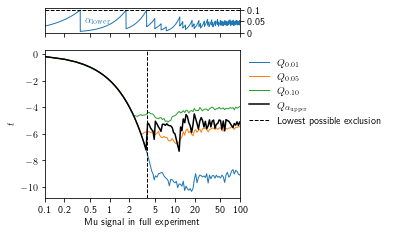

In [16]:
alpha_upper = (1 - confidence_level) - alpha_lower
    
orig_critical_t = stat.dist(quantiles=1 - confidence_level).ppf(rate=mu_full)

critical_t = np.array([
    stat.dist(quantiles=alpha).ppf(rate=mu)
    for alpha, mu in zip(alpha_upper, tqdm(mu_full))],
)



f, axes = plt.subplots(
    2, 1, 
    figsize=(3.5, 3.5), 
    sharex=True, 
    gridspec_kw=dict(height_ratios=[1,6]))

ax = axes[0]
plt.sca(ax)
common.log_x(0.1, 100)

plt.plot(mu,
         alpha_lower_hr, 
         c='C0', linewidth=1)
plt.text(0.65, 0.06, r"$\alpha_\mathrm{lower}$", 
         c='C0',
         ha='center', va='center')
plt.axhline(0.1, linewidth=1, c='k', linestyle='--')

plt.ylim(0, 0.11)
plt.yticks([0, .05, .1])
ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
ax.yaxis.tick_right()

ax = axes[1]
plt.sca(ax)

for alpha in [0.01, 0.05, 0.1]:
    y = stat.dist(quantiles=alpha).ppf(rate=mu_full)
    plt.plot(mu_full, 
             stat.dist(quantiles=alpha).ppf(rate=mu_full), 
             label=f'$Q_{{{alpha:.2f}}}$',
             linewidth=1)


plt.plot(mu_full, 
         critical_t,
         label=r'$Q_{\alpha_\mathrm{upper}}$',
         c='k')

plt.axvline(
    mu_never_exclude, 
    c='k', linestyle='--', linewidth=1,
    label='Lowest possible exclusion')

plt.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    
plt.xlabel("Mu signal in full experiment")
plt.ylabel("$t$")

Make the deficit hawk use this modified critical value. My apologies for this ugly hack. Hypney should allow this in a simpler way...

In [17]:
ul = hp.UpperLimit(stat, anchors=mu_full.tolist())
ul_orig = hp.UpperLimit(stat, anchors=mu_full.tolist())

def modified_ppf(*, params):
    return np.interp(x=params['rate'], xp=mu_full, fp=critical_t)
    
ul._ppf_pre_fudge = modified_ppf
ul.crit_at_anchors = critical_t

Test with some example data

In [18]:
# Just some example dataset
data = np.array([0., 0.5, 0.7])
# Limit with modified PPF, limit with original PPF (if you do only deficit hawk)
ul(data=data), ul_orig(data=data)

(9.100000000412683, 8.660329212137496)

## Combined procedure

In [19]:
def combined_procedure(data):
    n_core = np.sum(data < f_core).astype(int)
    lower = fc_limit_info['lower'][n_core] / f_core
    upper = max(mu_never_exclude, ul(data))
    upper_coreonly = fc_limit_info['upper'][n_core] / f_core
    return (lower, upper, upper_coreonly)

# Test on some example data again
combined_procedure(data)

(0.3510168739245596, 9.100000000412683, 14.532294376943094)

A (crazy) example that gives an empty interval (lower limit > upper limit)

In [20]:
combined_procedure(np.ones(13) * 0.1)

(24.74169198064821, 23.309678320908155, 66.87246022613667)

Find mean upper/lower limits with MC

In [21]:
mu_sigs = mu_full[mu_full < 30]
n_trials = 10_000

def draw_results(mu_sig):
    return np.asarray([
        combined_procedure(
            (background + signal(rate=mu_sig)).simulate())
        for _ in range(n_trials)])

cache_fn = Path(f'discovery_{f_core=:0.3f}_{n_trials=:07d}_{mu_unknown=:0.2f}.pkl')
if cache_fn.exists():
    # Load results from cache
    with open(cache_fn, mode='rb') as f:
        results = pickle.load(f)
else:
    # Do computation
    with ProcessPoolExecutor(max_workers=7) as exc:
        results = np.stack(list(tqdm(
            exc.map(draw_results, mu_sigs), 
            total=len(mu_sigs))))
    
    # Dump results to cache
    with open(cache_fn, mode='wb') as f:
        pickle.dump(results, f)

In [22]:
result_types = ['lower', 'upper', 'upper_core']

quantiles = {
    result_name: {
        n_sigma: np.quantile(results[...,i], stats.norm.cdf(n_sigma), axis=1)
        for n_sigma in [-2, -1, 0, 1, 2]}
    for i, result_name in enumerate(result_types)
}
means = {
    result_name: np.mean(results[...,i], axis=1)
    for i, result_name in enumerate(result_types)
}
p_empty = np.mean(results[...,0] >= results[...,1], axis=1)
p_worse = np.mean(results[...,1] >= results[...,2], axis=1)
p_clipped = np.mean(results[...,1] == mu_never_exclude, axis=1)

Probability of 'peculiar features'. (1) and (3) should be nearly impossible, and (2) should be really rare at 0 signal.

Text(0, 0.5, 'Probability')

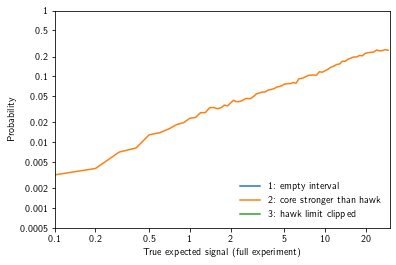

In [23]:
plt.plot(mu_sigs, p_empty, label='1: empty interval')
plt.plot(mu_sigs, p_worse, label='2: core stronger than hawk')
plt.plot(mu_sigs, p_clipped, label="3: hawk limit clipped")
plt.legend(loc='lower right', frameon=False)
common.log_y(.0005, 1)
common.log_x(0.1, 30)
plt.xlabel("True expected signal (full experiment)")
plt.ylabel("Probability")

In [27]:
p_worse[-1], mu_sigs[-1]

(0.2495, 29.3)

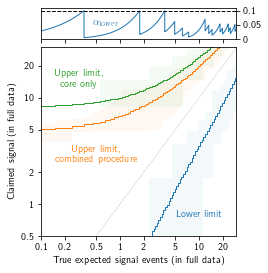

In [24]:
xlim = (mu_sigs[0], mu_sigs[-1])

f, axes = plt.subplots(
    2, 1, 
    figsize=(3.5, 4.2), 
    sharex=True, 
    gridspec_kw=dict(height_ratios=[1,6]))

ax = axes[0]
plt.sca(ax)
plt.plot(mu,
         alpha_lower_hr, 
         c='C0', linewidth=1)
plt.text(0.65, 0.06, r"$\alpha_\mathrm{lower}$", 
         c='C0',
         ha='center', va='center')
plt.axhline(0.1, linewidth=1, c='k', linestyle='--')
plt.ylim(0, 0.11)
plt.yticks([0, .05, .1])
ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
ax.yaxis.tick_right()

plt.sca(axes[1])

colors = dict(lower='C0', upper='C1', upper_core='C2')
labels = dict(lower='Lower limit', upper='Upper limit,\ncombined procedure', upper_core='Upper limit,\ncore only')

for qname, q in quantiles.items():
    plt.fill_between(
        mu_sigs, q[-1], q[+1], 
        alpha=0.05, linewidth=0,
        step='mid',
        color=colors[qname])
    plt.plot(
        mu_sigs,
        means[qname],
        color=colors[qname], 
        linewidth=1,
        drawstyle='steps-mid',
        label=labels[qname]
    )
    
plt.plot([0.1, 30], [0.1, 30], c='k', linewidth=0.1, linestyle='-')
    
label_locs = dict(
    lower=(10, 0.8),
    upper=(0.5, 2.9),
    upper_core=(0.3, 15))

for qname, (x, y) in label_locs.items():
    plt.text(x, y, labels[qname], color=colors[qname], ha='center', va='center')

common.log_x(*xlim)
common.log_y(0.5, 30)

plt.xlabel("True expected signal events (in full data)")
plt.ylabel("Claimed signal (in full data)")

plt.subplots_adjust(hspace=0.07)

for fmt in 'png', 'pdf':
    plt.savefig(f'discovery_study.{fmt}', dpi=300, bbox_inches='tight')